# Dynamic Solver Tutorial

This notebook walks through QCOM’s **dynamic solver** for evolving quantum states under **time‑dependent Hamiltonians**.  
You’ll learn how to connect model‑specific controls to a generic time series via **adapters**, run time evolution with a **piecewise‑constant (PWC)** propagator, record trajectories, compute probabilities in the computational basis, and validate against a dense reference on small systems.

> **Modular design.**  
> - The dynamic solver is **Hamiltonian‑agnostic**. It consumes a **TimeSeries** of channels and an **adapter** that maps channel values at time \(t\) to the parameters your static Hamiltonian **builder** expects.  
> - This keeps the solver generic and lets you plug in other models later.

**Contents**

1) [Setup](#setup)  
2) [A minimal 2‑site Rydberg example](#ex)  
3) [Adapters: mapping channels → Hamiltonian params](#adapters)  
4) [Pick a simulation window](#window)  
5) [Initial states & basis conventions](#init)  
6) [Evolve on a chosen time grid (PWC)](#evolve)  
7) [Snapshots, observables, and probabilities](#snapshots)  
8) [Validation vs. dense reference on tiny systems](#validate)  
9) [Performance tips & gotchas](#perf)  
10) [Extending to other Hamiltonians](#extend)

## 1) Setup <a id='setup'></a>

We assume you have installed QCOM and (optionally) SciPy for dense/sparse linear algebra:

```bash
pip install qcom scipy
```

Explicit imports keep things future‑proof:

In [2]:
import qcom as qc
import numpy as np
import matplotlib.pyplot as plt

# Optional helpers for norms of sparse/dense matrices
from scipy.sparse import issparse
from scipy.sparse.linalg import norm as sparse_norm
import scipy.linalg as sla

## 2) A minimal 2‑site Rydberg example <a id='ex'></a>

We build a tiny register with two **sites** separated by $ 5\,\mu\text{m} $, create a static `RydbergHamiltonian` once with placeholder parameters (they’ll be overridden at evolve time), and prepare a **time series** for the control channels `Omega`, `Delta`, `Phi`.

RydbergHamiltonian(N=2, Omega∈[0.000e+00,0.000e+00], Delta∈[0.000e+00,0.000e+00], phi∈[0.000e+00,0.000e+00])
N sites: 2 Hilbert dim: 4
TimeSeries(mode='absolute', channels=Omega[L=4, 0.000e+00→2.000e-06s], Delta[L=2, 0.000e+00→2.000e-06s], Phi[L=2, 0.000e+00→2.000e-06s])


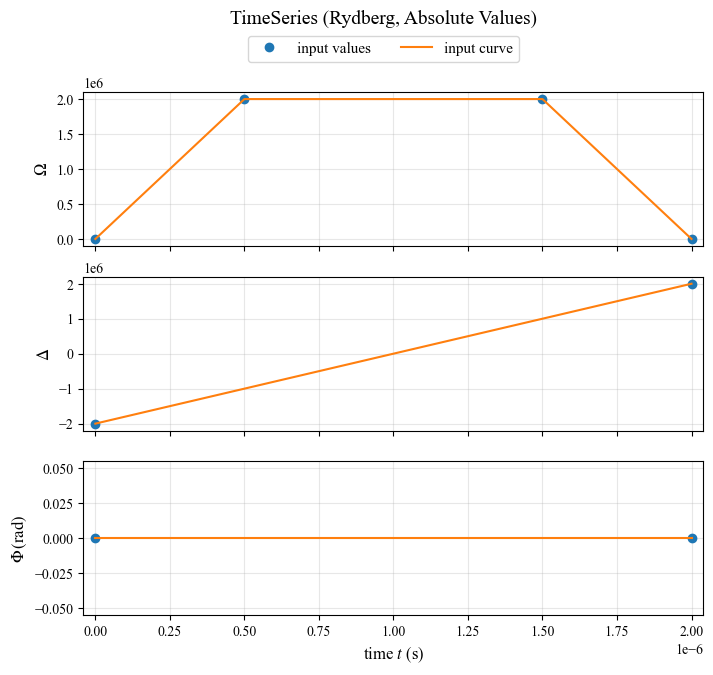

In [3]:
# --- geometry: two sites, 5 µm apart ---
reg = qc.LatticeRegister([(0.0, 0.0, 0.0), (5e-6, 0.0, 0.0)])
# optionally print/view the register
# print(reg)
# fig, ax = reg.plot()

# --- static Hamiltonian "skeleton" (params will be replaced at each t via adapter) ---
C6 = 2*np.pi * 1.0e6 * (5e-6)**6  # illustrative units: rad·s^-1·m^6
H_static = qc.build_rydberg(
    register=reg,
    C6=C6,
    Omega=0.0,        # placeholders
    Delta=0.0,
    Phi=0.0,
)
print(H_static)
print("N sites:", H_static.num_sites, "Hilbert dim:", H_static.hilbert_dim)

# --- controls ---
ts = qc.TimeSeries(mode="absolute")
# simple trapezoid on Omega (rad/s)
ts.add_series("Omega", [0.0e-6, 0.5e-6, 1.5e-6, 2.0e-6], [0.0, 2.0e6, 2.0e6, 0.0])
# chirp Delta from negative to positive (rad/s)
ts.add_series("Delta", [0.0e-6, 2.0e-6], [-2.0e6, 2.0e6])
# a zero constant phase (radians)
ts.add_series("Phi",   [0.0e-6, 2.0e-6], [0.0, 0.0])

print(ts)
fig, axes = ts.plot(style="auto")
plt.show()

## 3) Adapters: mapping channels → Hamiltonian params <a id='adapters'></a>

An **adapter** is a small object that conforms to the solver’s protocol
(`required_channels` and `hamiltonian_at(t, controls)`). At each step, the solver samples
the requested channels from `TimeSeries`, hands those **scalar** values to the adapter,
and the adapter produces the instantaneous Hamiltonian.

For the **Rydberg** model, our adapter expects channels `Omega`, `Delta`, and `Phi`. It combines
them with the fixed geometry (`register`) and interaction strength (`C6`) to build \(H(t)\) via
the static builder `build_rydberg(...)`.

> **Absolute vs. normalized:** If you constructed `TimeSeries(mode="normalized")`, you can provide
> site‑wise scaling to the adapter (e.g., `omega_max`, `delta_span`) so that scalar envelopes are
> expanded into per‑site arrays automatically. In this tutorial we’re using **absolute** mode.

In [4]:
# Instantiate the adapter for absolute mode
adapter = qc.RydbergAdapter(register=reg, C6=C6)
adapter  # repr

## 4) Pick a simulation window <a id='window'></a>

The solver evolves over the **union domain** of your `TimeSeries`. If you need a sub‑interval,
trim your controls beforehand. Here we’ll just read it and build a plotting grid.

In [5]:
t_min, t_max = ts.domain()
t_eval = np.linspace(t_min, t_max, 6)
print("domain:", (t_min, t_max), " grid points:", len(t_eval))

domain: (0.0, 2e-06)  grid points: 6


## 5) Initial states & basis conventions <a id='init'></a>

The computational basis uses **MSB ↔ site 0** (your register insertion order).  
- $ \ket{00}$ means both sites are in the ground state.  
- $\ket{10}$ means site 0 (MSB) is excited, site 1 is ground, etc.

Prepare an initial state as a length‑ $2^N$ complex vector with unit norm:

In [6]:
N = len(reg)
dim = 1 << N

# |00> ground state
psi0 = np.zeros(dim, dtype=np.complex128)
psi0[0] = 1.0

# sanity
print("dim:", dim, "norm:", np.vdot(psi0, psi0))

dim: 4 norm: (1+0j)


## 6) Evolve on a chosen time grid (PWC) <a id='evolve'></a>

The solver uses a **piecewise‑constant (PWC)** propagator: on each interval $[t_k, t_{k+1}]$,
it samples controls at the **midpoint** and applies $\exp[-iH(t )\Delta t]$.

For smoother results without changing the physics, run on a **refined grid** and (optionally)
down‑sample for visualization.

In [8]:
# --- PWC on t_eval ------------------------------------------------------------
psiT_pwc, out_pwc = qc.evolve_state(
    time_series=ts,
    adapter=adapter,
    psi0=psi0,
    times=t_eval,              # explicit grid (includes both endpoints)
    normalize_each_step=True,
    record=True,               # keep trajectory
    show_progress=True,
)

print("PWC keys:", out_pwc.keys(), "| states:", len(out_pwc.get("states", [])))

# --- Refined PWC --------------------------------------------------------------
substeps = 5   # refine each interval by this factor (increase for smoother approximation)
t_refined = np.linspace(t_min, t_max, (len(t_eval) - 1) * substeps + 1)

psiT_ref, out_ref = qc.evolve_state(
    time_series=ts,
    adapter=adapter,
    psi0=psi0,
    times=t_refined,           # finer grid
    normalize_each_step=True,
    record=True,
    show_progress=True,
)

# If you want trajectories aligned with t_eval for plotting, decimate:
take = np.linspace(0, len(t_refined) - 1, len(t_eval)).round().astype(int)
states_ref_on_eval = [out_ref["states"][i] for i in take]

print("Refined keys:", out_ref.keys(), "| refined states:", len(out_ref.get("states", [])))

Starting: Time evolution...
Completed: Time evolution. Elapsed time: 0.05 seconds.                             0.00s
PWC keys: dict_keys(['times', 'states']) | states: 6
Starting: Time evolution...
Completed: Time evolution. Elapsed time: 0.37 seconds.                          :    0.00s
Refined keys: dict_keys(['times', 'states']) | refined states: 26


**Probabilities From State Vector**

You can get the bitstring probabilities by using the built in function ```statevector_to_probabilities()```.

In [9]:
probability_dictionary = qc.statevector_to_probabilities(psiT_pwc)
print(probability_dictionary)

{'00': 0.18431089460770114, '01': 0.3954309897959694, '10': 0.3954309897959694, '11': 0.024827125800360107}


Let’s visualize the **populations** of a few basis states over time for both runs.

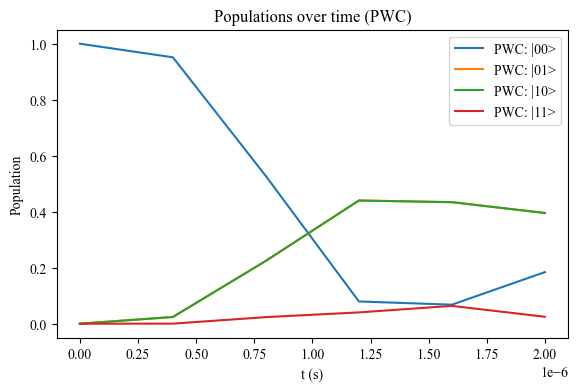

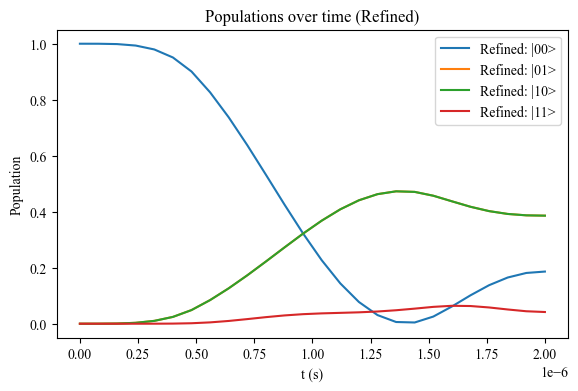

In [10]:
def populations(psi: np.ndarray) -> np.ndarray:
    """Return probability distribution from state vector."""
    return np.abs(psi) ** 2

def plot_populations(times, traj_states, compare_states, label):
    plt.figure(figsize=(6.6, 4.0))
    for idx, lab in compare_states:
        pops = [populations(psi)[idx] for psi in traj_states]
        plt.plot(times, pops, label=f"{label}: |{lab}>")
    plt.xlabel("t (s)")
    plt.ylabel("Population")
    plt.title(f"Populations over time ({label})")
    plt.legend()
    plt.show()

# choose basis states |00>, |01>, |10>, |11>
labels = ["00", "01", "10", "11"]
idxs = [int(s, 2) for s in labels]
compare_states = list(zip(idxs, labels))

# PWC run
plot_populations(out_pwc["times"], out_pwc["states"], compare_states, "PWC")

# Refined run (decimated back to t_eval for visual alignment)
plot_populations(out_ref["times"], out_ref["states"], compare_states, "Refined")

## 7) Snapshots, observables, and probabilities <a id='snapshots'></a>

The solver returns a **trajectory** when `record=True`:
- `out["times"]`: the evaluation grid  
- `out["states"]`: a list of state vectors \(\{\psi(t_k)\}\)

From these, you can compute probabilities or observables at **selected indices**.
Below, we inspect the first, middle, and last snapshots and report basis
populations of the final state.

In [12]:
# pick indices for snapshots
snap_ix = [0, len(out_pwc["times"])//2, len(out_pwc["times"])-1]
snap_times = [out_pwc["times"][i] for i in snap_ix]
snap_states = [out_pwc["states"][i] for i in snap_ix]

print("Snapshot times:", snap_times)

# Final state probabilities (direct computation)
final = out_pwc["states"][-1]
probs_direct = {format(i, f"0{N}b"): float(abs(final[i])**2) for i in range(1<<N)}

print("Final state probabilities (direct):")
for k in sorted(probs_direct):
    print(k, ":", f"{probs_direct[k]:.6f}")

Snapshot times: [0.0, 1.2e-06, 2e-06]
Final state probabilities (direct):
00 : 0.184311
01 : 0.395431
10 : 0.395431
11 : 0.024827


## 8) Validation vs. dense reference on tiny systems <a id='validate'></a>

For  small systems (e.g., $N\le 4$), you can compare the PWC evolution against a **dense reference** that uses many tiny time steps (left‑Riemann). This is slow but useful for sanity checks.

In [13]:
def _dense_matrix_of_H(t, adapter, ts):
    """Materialize a *dense* Hamiltonian matrix at time t using the adapter."""
    ctrls = {k: float(v[0]) for k, v in ts.value_at([t], channels=adapter.required_channels).items()}
    H_obj = adapter.hamiltonian_at(t, ctrls)

    # 1) Adapter returns an object with a dense method
    if hasattr(H_obj, "to_dense"):
        return np.asarray(H_obj.to_dense(), dtype=np.complex128)

    # 2) Adapter returns an object with a sparse method
    if hasattr(H_obj, "to_sparse"):
        H_sp = H_obj.to_sparse()
        return H_sp.toarray().astype(np.complex128, copy=False)

    # 3) Adapter returns a SciPy sparse matrix directly
    if issparse(H_obj):
        return H_obj.toarray().astype(np.complex128, copy=False)

    # 4) Otherwise assume array-like
    return np.asarray(H_obj, dtype=np.complex128)


def dense_reference(adapter, psi0, ts, t_eval, dt=2e-9):
    """
    Very simple dense reference via many tiny steps (for tiny Hilbert spaces only).
    Left-Riemann with step dt, sampling H(t) at the *left* endpoint.
    """
    psi = np.asarray(psi0, dtype=np.complex128).copy()
    snaps = [psi.copy()]

    t0 = float(t_eval[0])
    t1 = float(t_eval[-1])
    t = t0
    k = 1  # next index in t_eval we want to capture

    # march forward in tiny dense steps
    while t < t1 - 0.5 * dt:
        H = _dense_matrix_of_H(t, adapter, ts)  # dense ndarray
        U = sla.expm((-1j * H) * dt)
        psi = (U @ psi).astype(np.complex128, copy=False)

        # capture whenever we cross the next evaluation time
        while k < len(t_eval) and t >= (t_eval[k] - 0.5 * dt):
            snaps.append(psi.copy())
            k += 1

        t += dt

    # pad if we didn’t hit all evaluation points due to rounding
    while len(snaps) < len(t_eval):
        snaps.append(psi.copy())

    return np.asarray(snaps, dtype=np.complex128)

# WARNING: exponential for N>4 — here N=2, so it's fine.
psi_ref = dense_reference(adapter, psi0, ts, t_eval, dt=2e-9)

# Compare final state overlap (Refined vs dense)
ov_ref = np.vdot(psi_ref[-1], states_ref_on_eval[-1])
print("Overlap (Refined vs dense reference, final):", abs(ov_ref))

# Compare PWC vs dense as well
ov_pwc = np.vdot(psi_ref[-1], out_pwc["states"][-1])
print("Overlap (PWC vs dense reference, final):", abs(ov_pwc))

Overlap (Refined vs dense reference, final): 0.9999968825190044
Overlap (PWC vs dense reference, final): 0.9986944243891221


## 9) Performance tips & gotchas <a id='perf'></a>

- The solver uses a **PWC midpoint propagator**. For smoother behavior, refine your time grid.
- Prefer **sparse** Hamiltonians internally for larger \(N\) (model‑dependent).
- Align your time grid with control **kinks** where possible.
- If your `TimeSeries` is in **normalized** mode, perform site‑dependent scaling inside the **adapter**.
- For custom models, write an adapter that returns exactly the kwargs your static builder expects.

## 10) Extending to other Hamiltonians <a id='extend'></a>

To plug in a new model:

1. Implement (or import) a **static** builder `my_build(register, **params) -> HamiltonianObject`
   that behaves like `RydbergHamiltonian` (should expose `.to_dense()` / `.to_sparse()` or return
   an array/sparse matrix compatible with the solver).
2. Create a small **adapter** (e.g., `HeisenbergAdapter`) that maps your channel names (e.g., `J`, `hx`, `hz`)
   at time `t` to the exact keyword arguments your builder needs.
3. Call `evolve_state(time_series=..., adapter=..., psi0=..., times=...)`.